In [61]:
import sys
sys.path.append('../..')
sys.path.append( '../../utilities' )
from utilities.get_data import get_historical_from_db
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month, basic_multi_asset_backtest
from utilities.custom_indicators import SuperTrend, VMC, chop
#from utilities.exchange_data_manager import ExchangeDataManager
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np
import json
import warnings
warnings.filterwarnings("ignore")
f = open('../../database/coin_list.json',)
pair_json = json.load(f)
f.close()

In [62]:

class VMC_strat():
    def __init__(
        self,
        df_list,
        oldest_pair,
        EMA_long_window = 200,
        EMA_short_window = 50,
        chop_window = 14,
        take_profit = 0.05,
        stop_loss = 0.05
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.EMA_long_window = EMA_long_window
        self.EMA_short_window = EMA_short_window
        self.chop_window = chop_window
        self.take_profit = take_profit
        self.stop_loss = stop_loss
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        for pair in self.df_list:
            df = self.df_list[pair]
            df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
        
            # -- Populate indicators --

            df['HLC3'] = (df['high'] +df['close'] + df['low'])/3
            vmc = VMC(high =df['high'],low = df['low'],close=df['HLC3'],open=df['open'])
            df['VMC_WAVE1'] = vmc.wave_1()
            df['VMC_WAVE2'] = vmc.wave_2()
            vmc = VMC(high =df['high'],low = df['low'],close=df['close'],open=df['open'])
            df['MONEY_FLOW'] = vmc.money_flow()
        
            df['ema_short'] = ta.trend.ema_indicator(close=df['close'], window=self.EMA_short_window)
            df['ema_long'] = ta.trend.ema_indicator(close=df['close'], window=self.EMA_long_window)

            df["CHOP"] = chop(df['high'],df['low'],df['close'],window=self.chop_window)

            df = get_n_columns(df, ["VMC_WAVE1","VMC_WAVE2", "MONEY_FLOW","ema_short", "ema_long", "CHOP"], 1)

            self.df_list[pair] = df
            # -- Log --
            if(show_log):
                print(self.df_list[self.oldest_pair])
                
        return self.df_list[self.oldest_pair]
    
    def populate_buy_sell(self, show_log=False): 
        data_open_long = []
        data_close_long = []

        for pair in self.df_list:
            df = self.df_list[pair]
            df["open_long"] = False
            df["close_long"] = False
            df["pair"] = pair
            df["null"] = np.nan
            
            # -- Populate open long --
            df.loc[
                (df['ema_short'] > df['ema_long']) 
                & (df['close'] > df['ema_short']) 
                & (df['MONEY_FLOW'] > 0)
                & (df['VMC_WAVE1'] < 0 ) 
                & (df['VMC_WAVE2'] < 0 ) 
                & (df['VMC_WAVE1'] > df['VMC_WAVE2'] )
                & (df['n1_VMC_WAVE1'] < df['n1_VMC_WAVE2'] ) 
                & (df['CHOP'] < 50 )
                
                , "open_long"
            ] = True
            
            # -- Populate close long --
            df.loc[
                (df['close'] > 1000000)
                , "close_long"
            ] = True
                
            # -- Populate pair list per date (do not touch)--
            data_open_long.append(
                df.loc[
                (df['open_long']  == True) 
                ]['pair']
            )
            data_close_long.append(
                df.loc[
                (df['close_long']  == True) 
                ]['pair']
            )

        data_open_long.append(self.df_list[self.oldest_pair]['null'])
        data_close_long.append(self.df_list[self.oldest_pair]['null'])
        df_open_long = pd.concat(data_open_long, axis=1)
        df_open_long['combined']= df_open_long.values.tolist()
        df_open_long['combined'] = [[i for i in j if i == i] for j in list(df_open_long['combined'])]
        df_close_long = pd.concat(data_close_long, axis=1)
        df_close_long['combined']= df_close_long.values.tolist()
        df_close_long['combined'] = [[i for i in j if i == i] for j in list(df_close_long['combined'])]
        self.open_long_obj = df_open_long['combined']
        self.close_long_obj = df_close_long['combined']
        
        # -- Log --
        if(show_log):
            print("Open LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["open_long"]==True]))
            print("Close LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["close_long"]==True]))
        
        return self.df_list[self.oldest_pair]
    
    def run_backtest(self, initial_wallet=1000, max_positions=3, return_type="metrics"):
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        usd_remaining = initial_wallet
        maker_fee = 0
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_positions = {}
        open_position_obj = {}
        take_profit = self.take_profit
        stop_loss = self.stop_loss
        
        for index, row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day 
            
            # Sell
            close_long_row = self.close_long_obj.loc[index]
            if len(current_positions) > 0:
                for pos in current_positions.copy():
                    actual_row = self.df_list[pos].loc[index]
                    if current_positions[pos]["stop_loss"] > actual_row["low"]:
                        close_price = current_positions[pos]["stop_loss"]
                        trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                        close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                        fee = close_size * maker_fee
                        wallet += close_size - current_positions[pos]['size'] - fee
                        usd_remaining += close_size - fee
                        trades.append({
                            "pair": pos,
                            "open_date": current_positions[pos]['date'],
                            "close_date": index,
                            "position": current_positions[pos]['side'],
                            "open_reason": current_positions[pos]['reason'],
                            "close_reason": "Stop Loss",
                            "open_price": current_positions[pos]['price'],
                            "close_price": close_price,
                            "open_fee": current_positions[pos]['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_positions[pos]['size'],
                            "close_trade_size":close_size,
                            "wallet": wallet,
                            "usd_remaining": usd_remaining
                        })
                        del current_positions[pos] 
                    elif current_positions[pos]["take_profit"] < actual_row["high"]:
                        close_price = current_positions[pos]["take_profit"]
                        trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                        close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                        fee = close_size * maker_fee
                        wallet += close_size - current_positions[pos]['size'] - fee
                        usd_remaining += close_size - fee
                        trades.append({
                            "pair": pos,
                            "open_date": current_positions[pos]['date'],
                            "close_date": index,
                            "position": current_positions[pos]['side'],
                            "open_reason": current_positions[pos]['reason'],
                            "close_reason": "Take Profit",
                            "open_price": current_positions[pos]['price'],
                            "close_price": close_price,
                            "open_fee": current_positions[pos]['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_positions[pos]['size'],
                            "close_trade_size":close_size,
                            "wallet": wallet,
                            "usd_remaining": usd_remaining
                        })
                        del current_positions[pos] 
                position_to_close = set(current_positions).intersection(set(close_long_row))
                for pos in position_to_close:
                    # print("Close",pos)
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['close']
                    trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - current_positions[pos]['size'] - fee
                    usd_remaining += close_size - fee
                    trades.append({
                        "pair": pos,
                        "open_date": current_positions[pos]['date'],
                        "close_date": index,
                        "position": current_positions[pos]['side'],
                        "open_reason": current_positions[pos]['reason'],
                        "close_reason": "Market",
                        "open_price": current_positions[pos]['price'],
                        "close_price": close_price,
                        "open_fee": current_positions[pos]['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_positions[pos]['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                        "usd_remaining": usd_remaining
                    })
                    del current_positions[pos]   
                    
            # Buy
            open_long_row = self.open_long_obj.loc[index]
            if len(open_long_row) > 0 and len(current_positions) < max_positions:
                for pos in open_long_row:
                    if len(current_positions) < max_positions and pos not in current_positions:
                        # print("Open",pos)
                        actual_row = self.df_list[pos].loc[index]
                        open_price = actual_row['close']
                        pos_size = usd_remaining / (max_positions - len(current_positions))
                        fee = pos_size * taker_fee
                        wallet -= fee
                        usd_remaining -= pos_size+fee
                        current_positions[pos] = {
                            "take_profit": actual_row['close'] +2*(actual_row['close']-actual_row['ema_long']),
                            "stop_loss": actual_row['ema_long'],
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": "Market",
                            "side": "LONG"
                        }
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if return_type == "metrics":
            return get_metrics(df_trades, df_days) | {
                "wallet": wallet,
                "trades": df_trades,
                "days": df_days
            }  
        else:
            return True

In [63]:
pair_list = ['BTC/USDT', 'ETH/USDT','EGLD/USDT', 'AVAX/USDT', 'ADA/USDT', 'MATIC/USDT', 'LINK/USDT', 'SOL/USDT', 'FTM/USDT', "DOGE/USDT"]
tf = '1h'
oldest_pair = "BTC/USDT"

df_list = {}
for pair in pair_list:
    df = get_historical_from_db(ccxt.binance(), pair, tf, path="../../database/")
    df_list[pair] = df.loc["2017":]

print("Data load 100%")
df_list[oldest_pair]

Data load 100%


,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-06-01 15:00:00,31172.48,31239.14,30600.00,30742.59,10280.121970
2022-06-01 16:00:00,30742.59,30744.19,30291.67,30419.62,14127.395730
2022-06-01 17:00:00,30419.62,30429.71,29901.29,30179.67,11518.461400


Open LONG length on oldest pair : 53
Close LONG length on oldest pair : 0
Period: [2017-08-17 00:00:00] -> [2022-06-01 00:00:00]
Initial wallet: 1000.0 $
Trades on 10 pairs

--- General Information ---
Final wallet: 5899.22 $
Performance vs US dollar: 489.92 %
Sharpe Ratio: 1.82
Worst Drawdown T|D: -15.5% | -15.5%
Buy and hold performance: 641.19 %
Performance vs buy and hold: -20.41 %
Total trades on the period: 308
Global Win rate: 47.08 %
Average Profit: 4.47 %

----- Pair Result -----
-----------------------------------------------------------------------------------------------
Trades      Pair     Sum-result     Mean-trade    Worst-trade     Best-trade       Win-rate
-----------------------------------------------------------------------------------------------
48      ETH/USDT       168.82 %         3.52 %       -19.72 %        26.46 %         50.0 %
45      BTC/USDT       146.12 %         3.25 %        -10.0 %        23.89 %        48.89 %
45      ADA/USDT        84.26 %       

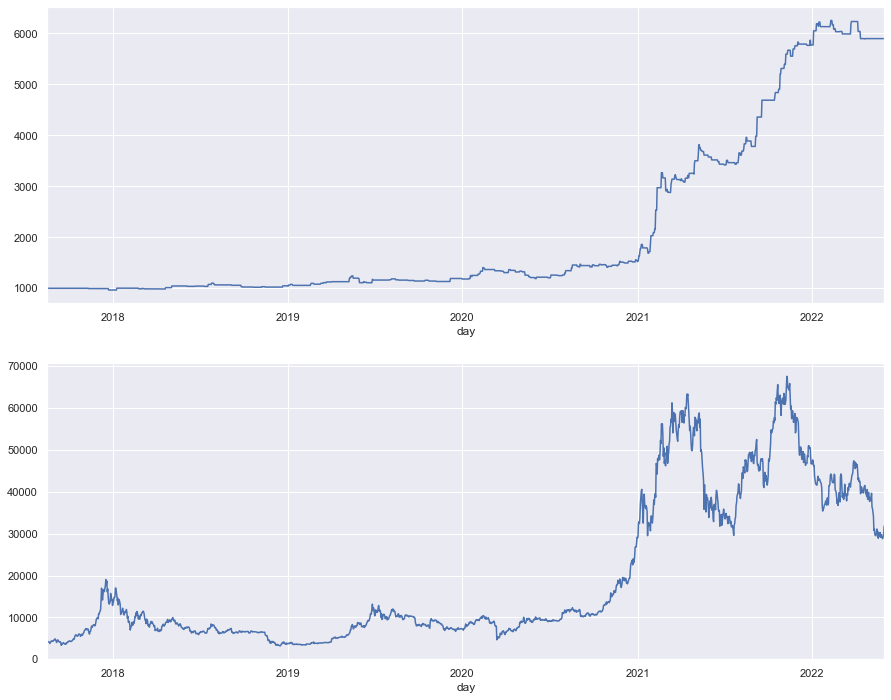

In [64]:
strat = VMC_strat(
    df_list=df_list,
    oldest_pair=oldest_pair,
    EMA_long_window = 200,
    EMA_short_window = 50,
    chop_window = 14,
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=True)
bt_result = strat.run_backtest(initial_wallet=1000, max_positions=7)

df_trades, df_days = basic_multi_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=bt_result['days'])

In [65]:
bt_result['trades'].iloc[-20:]

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,usd_remaining
open_date,,,,,,,,,,,,,,
2022-02-06 17:00:00,MATIC/USDT,2022-02-06 17:00:00,2022-02-07 04:00:00,LONG,Market,Take Profit,1.696,1.785465,0.613444,0.0,876.347867,922.575937,6179.538592,4426.863293
2022-02-05 22:00:00,ADA/USDT,2022-02-05 22:00:00,2022-02-08 00:00:00,LONG,Market,Take Profit,1.131,1.229718,0.613515,0.0,876.450120,952.950269,6256.038741,5379.813562
2022-02-10 08:00:00,MATIC/USDT,2022-02-10 08:00:00,2022-02-11 02:00:00,LONG,Market,Stop Loss,1.997,1.816036,0.627557,0.0,896.510065,815.270380,6173.543854,4400.683082
2022-02-08 19:00:00,AVAX/USDT,2022-02-08 19:00:00,2022-02-14 00:00:00,LONG,Market,Stop Loss,85.500,76.930737,0.627645,0.0,896.635594,806.770025,6083.678285,5207.453107
2022-02-16 17:00:00,MATIC/USDT,2022-02-16 17:00:00,2022-02-16 18:00:00,LONG,Market,Take Profit,1.771,1.786184,0.607536,0.0,867.908851,875.349879,6090.511777,5214.286599
2022-02-06 21:00:00,ETH/USDT,2022-02-06 21:00:00,2022-02-18 14:00:00,LONG,Market,Stop Loss,2994.060,2804.093642,0.613358,0.0,876.225179,820.630666,6034.917265,6034.917265
2022-02-27 07:00:00,AVAX/USDT,2022-02-27 07:00:00,2022-02-27 08:00:00,LONG,Market,Stop Loss,79.220,78.537123,0.603421,0.0,862.030456,854.599744,6026.279640,5164.148602
2022-02-27 06:00:00,ETH/USDT,2022-02-27 06:00:00,2022-02-27 10:00:00,LONG,Market,Take Profit,2732.200,2775.201481,0.603492,0.0,862.131038,875.699924,6039.848526,6039.848526
2022-03-03 07:00:00,BTC/USDT,2022-03-03 07:00:00,2022-03-04 01:00:00,LONG,Market,Stop Loss,43477.050,41079.325870,0.603985,0.0,862.835504,815.250824,5991.659861,5991.659861


----- 2017 Cumulative Performances: -3.4% -----


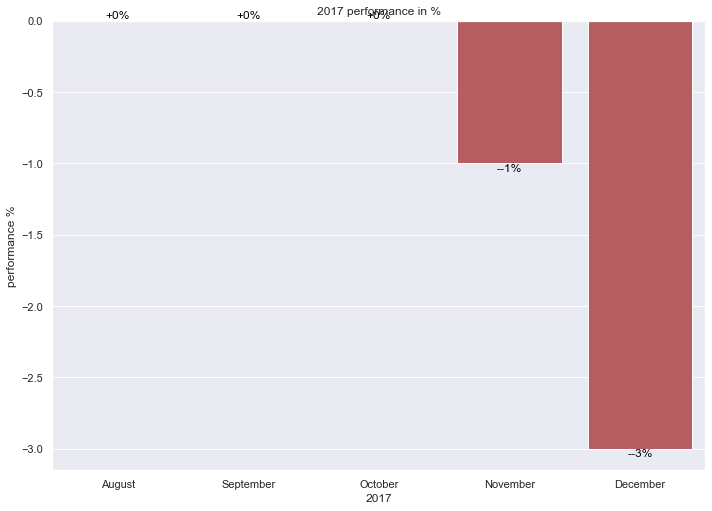

----- 2018 Cumulative Performances: 8.51% -----


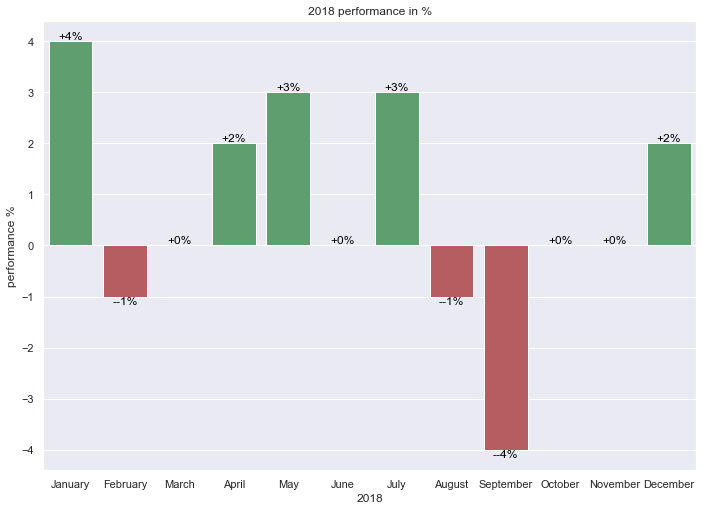

----- 2019 Cumulative Performances: 13.46% -----


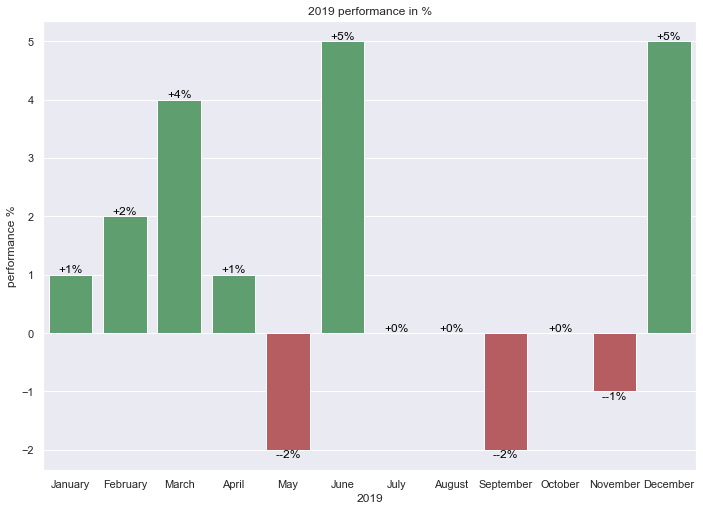

----- 2020 Cumulative Performances: 30.71% -----


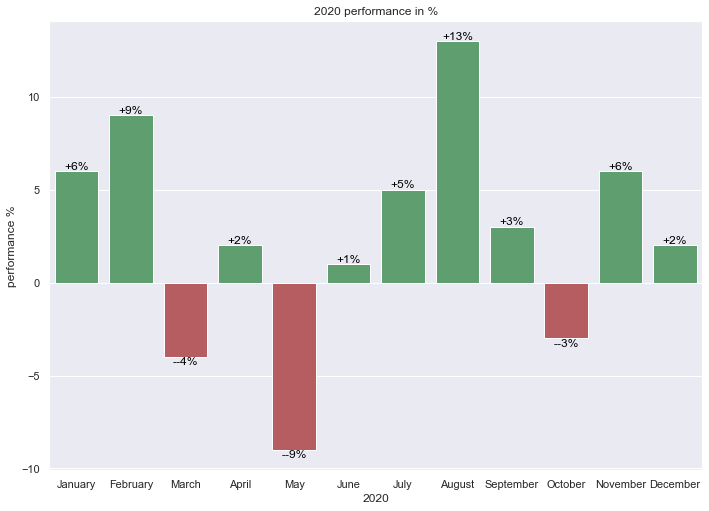

----- 2021 Cumulative Performances: 278.32% -----


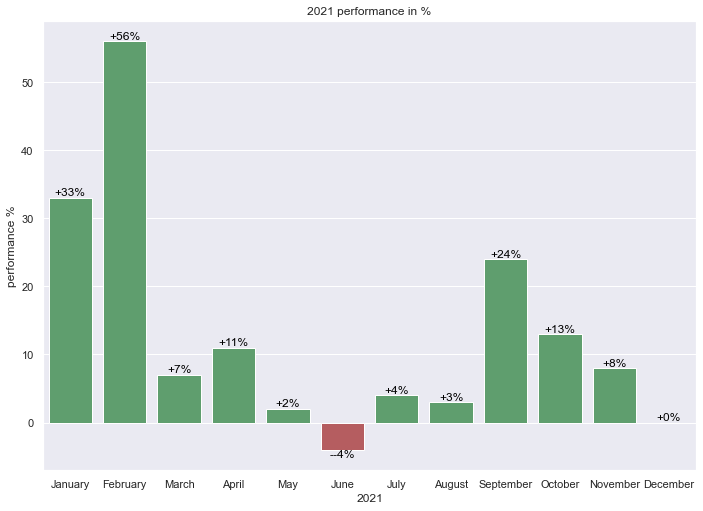

----- 2022 Cumulative Performances: 2.16% -----


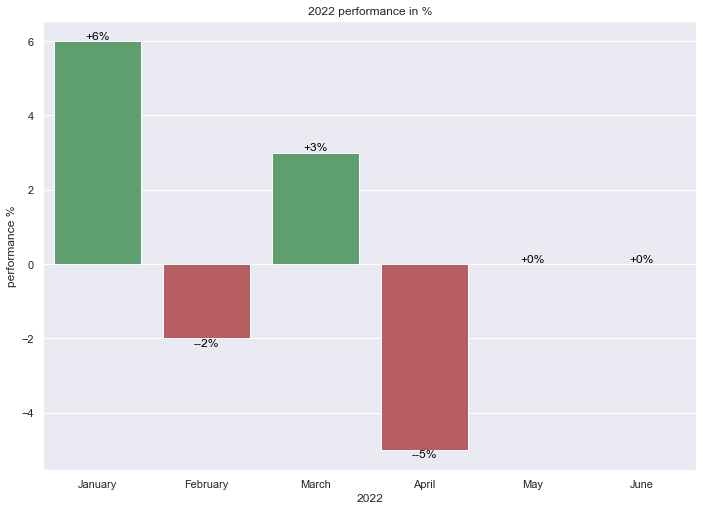

In [66]:
plot_bar_by_month(bt_result['days'])